# Spatial Joins

A *spatial join* uses [binary predicates](http://toblerity.org/shapely/manual.html#binary-predicates) 
such as `intersects` and `crosses` to combine two `GeoDataFrames` based on the spatial relationship 
between their geometries.

A common use case might be a spatial join between a point layer and a polygon layer where you want to retain the point geometries and grab the attributes of the intersecting polygons.


In [1]:
from IPython.core.display import Image 
Image(url='https://web.natur.cuni.cz/~langhamr/lectures/vtfg1/mapinfo_1/about_gis/Image23.gif') 


## Types of spatial joins

We currently support the following methods of spatial joins. We refer to the *left_df* and *right_df* which are the correspond to the two dataframes passed in as args.

### Left outer join

In a LEFT OUTER JOIN (`how='left'`), we keep *all* rows from the left and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right if they intersect and lose right rows that don't intersect. A left outer join implies that we are interested in retaining the geometries of the left. 

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
LEFT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
 0101000000818693BA2F8FF7BF4ADD97C75604E9BF |    1 |       
(5 rows)
```

### Right outer join

In a RIGHT OUTER JOIN (`how='right'`), we keep *all* rows from the right and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the left if they intersect and lose left rows that don't intersect. A right outer join implies that we are interested in retaining the geometries of the right. 

This is equivalent to the PostGIS query:
```
SELECT polys.geom, pts.id as ptid, polys.id as polyid  
FROM pts
RIGHT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

  geom    | ptid | polyid 
----------+------+--------
 01...9BF |    4 |     10
 01...9BF |    3 |     10
 02...7BF |    3 |     20
 02...7BF |    2 |     20
 00...5BF |      |     30
(5 rows)
```

### Inner join

In an INNER JOIN (`how='inner'`), we keep rows from the right and left only where their binary predicate is `True`. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not. An inner join implies that we are interested in retaining the geometries of the left. 

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
INNER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
(4 rows) 
```

## Spatial Joins between two GeoDataFrames

Let's take a look at how we'd implement these using `GeoPandas`. First, load up the NYC test data into `GeoDataFrames`:

In [2]:
%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay

# NYC Boros
zippath = datasets.get_path('nybb')
polydf = read_file(zippath)

# Generate some points
b = [int(x) for x in polydf.total_bounds]
N = 8
pointdf = GeoDataFrame([
    {'geometry': Point(x, y), 'value1': x + y, 'value2': x - y}
    for x, y in zip(range(b[0], b[2], int((b[2] - b[0]) / N)),
                    range(b[1], b[3], int((b[3] - b[1]) / N)))])

# Make sure they're using the same projection reference
pointdf.crs = polydf.crs

In [3]:
pointdf

,geometry,value1,value2
0,POINT (913175 120121),1033296,793054
1,POINT (932450 139211),1071661,793239
2,POINT (951725 158301),1110026,793424
3,POINT (971000 177391),1148391,793609
4,POINT (990275 196481),1186756,793794
5,POINT (1009550 215571),1225121,793979
6,POINT (1028825 234661),1263486,794164
7,POINT (1048100 253751),1301851,794349
8,POINT (1067375 272841),1340216,794534


In [4]:
polydf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


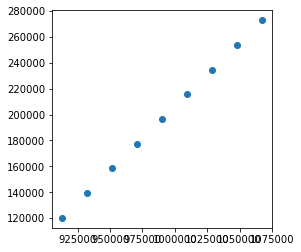

In [5]:
pointdf.plot()

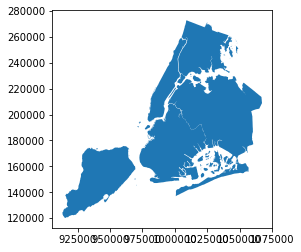

In [6]:
polydf.plot()

## Joins

In [7]:
from geopandas.tools import sjoin
join_left_df = sjoin(pointdf, polydf, how="left")
join_left_df
# Note the NaNs where the point did not intersect a boro

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,POINT (913175 120121),1033296,793054,NaN,NaN,NaN,NaN,NaN
1,POINT (932450 139211),1071661,793239,0.0,5.0,Staten Island,330470.010332,1.623820e+09
2,POINT (951725 158301),1110026,793424,0.0,5.0,Staten Island,330470.010332,1.623820e+09
3,POINT (971000 177391),1148391,793609,NaN,NaN,NaN,NaN,NaN
4,POINT (990275 196481),1186756,793794,NaN,NaN,NaN,NaN,NaN
5,POINT (1009550 215571),1225121,793979,1.0,4.0,Queens,896344.047763,3.045213e+09
6,POINT (1028825 234661),1263486,794164,4.0,2.0,Bronx,464392.991824,1.186925e+09
7,POINT (1048100 253751),1301851,794349,NaN,NaN,NaN,NaN,NaN
8,POINT (1067375 272841),1340216,794534,NaN,NaN,NaN,NaN,NaN


In [8]:
join_right_df = sjoin(pointdf, polydf, how="right")
join_right_df
# Note Staten Island is repeated

,index_left,value1,value2,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
index_right,,,,,,,,
0,1.0,1071661.0,793239.0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
0,2.0,1110026.0,793424.0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,5.0,1225121.0,793979.0,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
4,6.0,1263486.0,794164.0,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...
2,NaN,NaN,NaN,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,NaN,NaN,NaN,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...


In [9]:
join_inner_df = sjoin(pointdf, polydf, how="inner")
join_inner_df
# Note the lack of NaNs; dropped anything that didn't intersect

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
1,POINT (932450 139211),1071661,793239,0,5,Staten Island,330470.010332,1.623820e+09
2,POINT (951725 158301),1110026,793424,0,5,Staten Island,330470.010332,1.623820e+09
5,POINT (1009550 215571),1225121,793979,1,4,Queens,896344.047763,3.045213e+09
6,POINT (1028825 234661),1263486,794164,4,2,Bronx,464392.991824,1.186925e+09


We're not limited to using the `intersection` binary predicate. Any of the `Shapely` geometry methods that return a Boolean can be used by specifying the `op` kwarg.

In [10]:
sjoin(pointdf, polydf, how="left", op="within")

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,POINT (913175 120121),1033296,793054,NaN,NaN,NaN,NaN,NaN
1,POINT (932450 139211),1071661,793239,0.0,5.0,Staten Island,330470.010332,1.623820e+09
2,POINT (951725 158301),1110026,793424,0.0,5.0,Staten Island,330470.010332,1.623820e+09
3,POINT (971000 177391),1148391,793609,NaN,NaN,NaN,NaN,NaN
4,POINT (990275 196481),1186756,793794,NaN,NaN,NaN,NaN,NaN
5,POINT (1009550 215571),1225121,793979,1.0,4.0,Queens,896344.047763,3.045213e+09
6,POINT (1028825 234661),1263486,794164,4.0,2.0,Bronx,464392.991824,1.186925e+09
7,POINT (1048100 253751),1301851,794349,NaN,NaN,NaN,NaN,NaN
8,POINT (1067375 272841),1340216,794534,NaN,NaN,NaN,NaN,NaN
